C:\Users\user\AppData\Local\Temp\ipykernel_21812\3350675003.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["Vol."].fillna(data["Vol."].mean(), inplace=True)


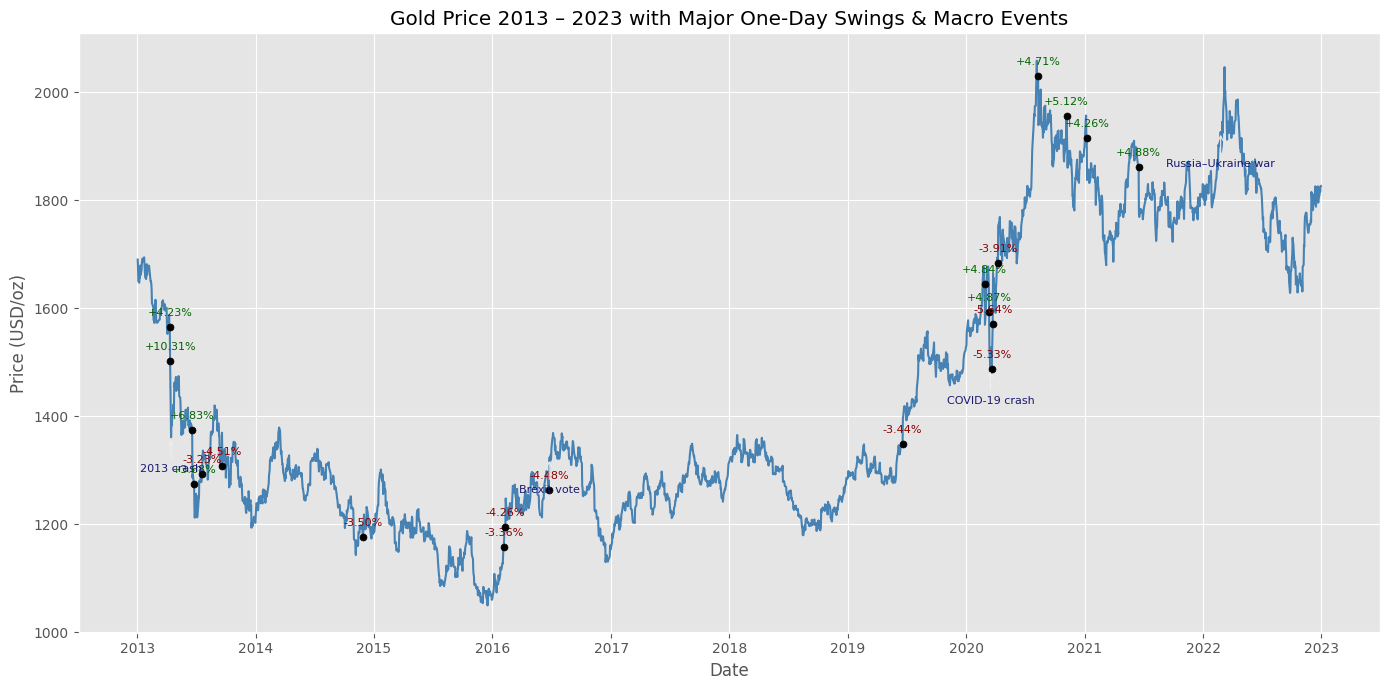

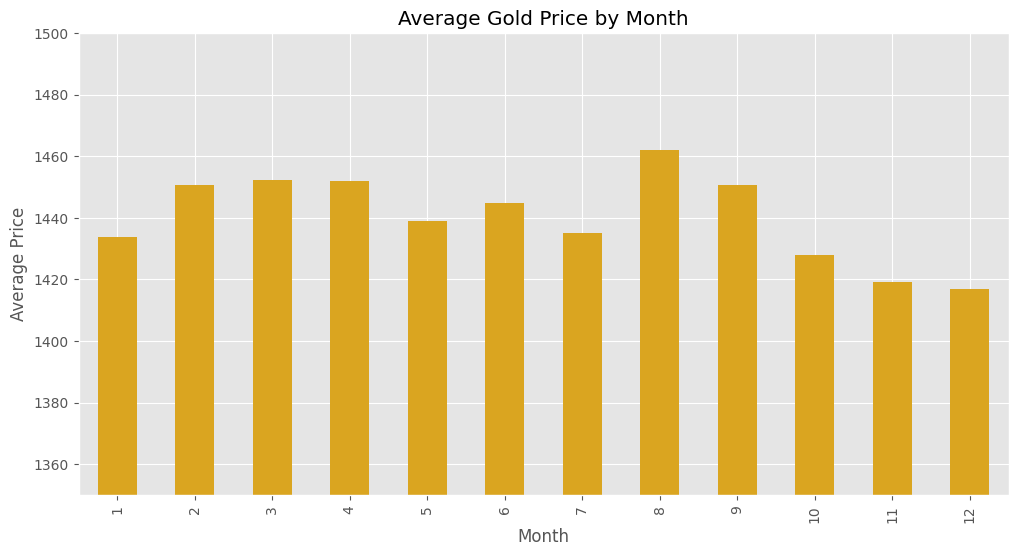

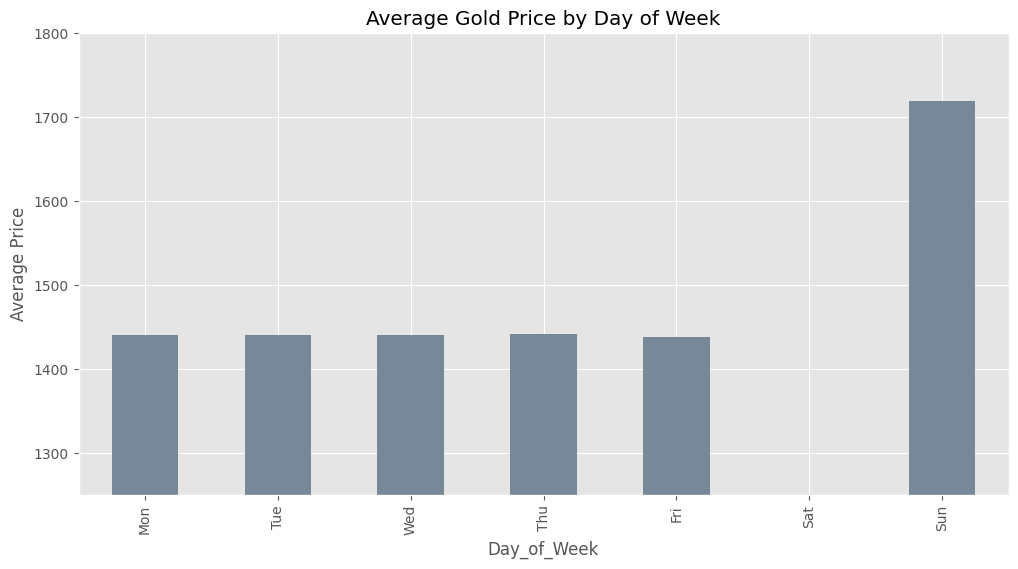

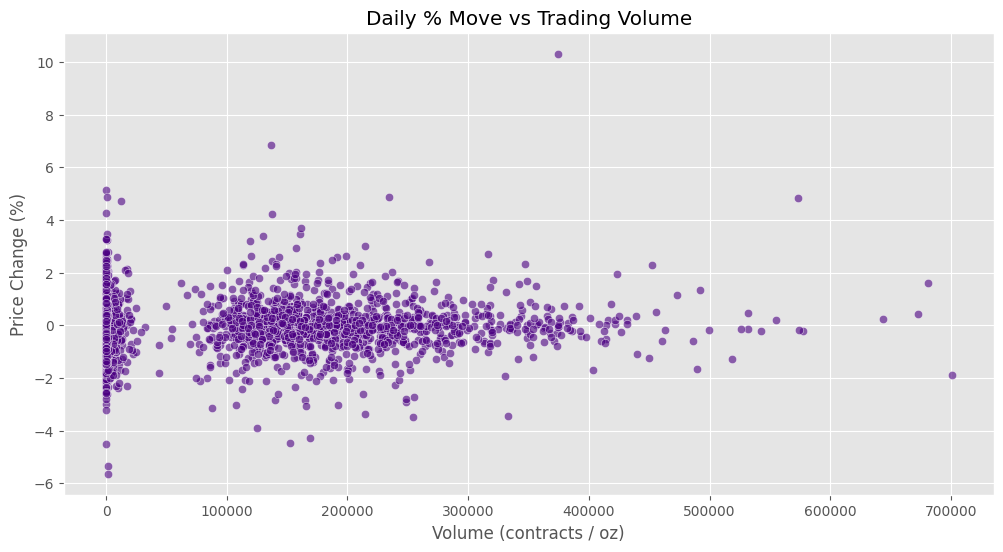

In [32]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter

plt.rcParams["figure.figsize"] = (12, 6)
plt.style.use("ggplot")  # remove if you prefer default

# 1. clean the gold price 
file = "gold_prices2013-2023.csv"   # <- change path if needed
data = pd.read_csv(file)

data["Date"] = pd.to_datetime(data["Date"], format="%m/%d/%Y")

for col in ["Price", "Open", "High", "Low"]:
    data[col] = data[col].str.replace(",", "", regex=False).astype(float)
def _parse_vol(v):
    if pd.isna(v) or v == "":
        return np.nan
    v = v.replace(",", "")
    factor = 1
    if v.endswith("K"):
        factor, v = 1e3, v[:-1]
    elif v.endswith("M"):
        factor, v = 1e6, v[:-1]
    return float(v) * factor

data["Vol."] = data["Vol."].apply(_parse_vol)
data["Vol."].fillna(data["Vol."].mean(), inplace=True)

data["Change %"] = data["Change %"].str.replace("%", "", regex=False).astype(float)

# 2. Engineering: daily % move & time features
data["Price Change %"] = data["Price"].pct_change() * 100
data["Day_of_Week"]    = data["Date"].dt.dayofweek        
data["Month"]          = data["Date"].dt.month

# 3. Identify “biggest events” = |daily %| Top-10
topN = 10
big_swings = pd.concat(
    [
        data.nlargest(topN,  "Price Change %"),
        data.nsmallest(topN, "Price Change %")
    ]
).copy().sort_values("Date")

# 4. Add a few famous macro events manually (editable)
macro_events = pd.DataFrame(
    {
        "Date": pd.to_datetime(
            [
                "2013-04-15",   # 2013 two-day crash
                "2016-06-24",   # Brexit vote
                "2020-03-16",   # COVID-19 panic
                "2022-02-24",   # Russia-Ukraine war
            ]
        ),
        "Event": [
            "2013 crash",
            "Brexit vote",
            "COVID-19 crash",
            "Russia–Ukraine war",
        ],
    }
)
macro_events = macro_events[
    macro_events["Date"].between(data["Date"].min(), data["Date"].max())
]

# 5. Plot – Gold price with event annotations
fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(data["Date"], data["Price"], color="steelblue", lw=1.5)
ax.set_title("Gold Price 2013 – 2023 with Major One-Day Swings & Macro Events")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD/oz)")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))

# --- annotate data-driven big swings
for _, row in big_swings.iterrows():
    ax.annotate(
        f"{row['Price Change %']:+.2f}%",
        xy=(row["Date"], row["Price"]),
        xytext=(0, 8),
        textcoords="offset points",
        ha="center",
        fontsize=8,
        color="darkred" if row["Price Change %"] < 0 else "darkgreen",
    )
    ax.scatter(row["Date"], row["Price"], color="black", s=25, zorder=3)

# --- annotate manual macro events
for _, row in macro_events.iterrows():
    price_here = data.loc[data["Date"] == row["Date"], "Price"]
    if not price_here.empty:
        ax.annotate(
            row["Event"],
            xy=(row["Date"], price_here.values[0]),
            xytext=(0, -25),
            textcoords="offset points",
            arrowprops=dict(arrowstyle="->", lw=0.8),
            ha="center",
            fontsize=8,
            color="midnightblue",
        )

plt.tight_layout()
plt.show()

# 6. Average price by month (y-axis starts 1350)
(data.groupby("Month")["Price"]
 .mean()
 .plot(kind="bar", color="goldenrod",
       title="Average Gold Price by Month", ylabel="Average Price"))
plt.ylim(1350, 1500)
plt.show()

# 7. Average price by day-of-week (Mon…Sun)
dow_labels = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
dow_avg = data.groupby("Day_of_Week")["Price"].mean()
dow_avg = dow_avg.reindex(range(7))  # ensure missing days show as NaN
(dow_avg.plot(kind="bar", color="lightslategray",
              title="Average Gold Price by Day of Week", ylabel="Average Price"))
plt.xticks(ticks=range(7), labels=dow_labels)
plt.ylim(1250, 1800)
plt.show()

# 8. Volume vs daily 
sns.scatterplot(
    data=data, x="Vol.", y="Price Change %", alpha=0.6, color="indigo"
)
plt.title("Daily % Move vs Trading Volume")
plt.xlabel("Volume (contracts / oz)")
plt.ylabel("Price Change (%)")
plt.show()
